# Import, Init

In [1]:
# import tensorflow as tf
# tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nwch7mfe because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [3]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

>>> train-test inited:  {'y_test': True, 'X_test': True, 'y_train': True, 'X_train': True}


In [4]:
# loaded

nn_manager_cut.X_test.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY',
       'PRICE_UP'],
      dtype='object')

In [5]:
nn_manager_cut.X_test.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], inplace=True)
nn_manager_cut.X_train.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], inplace=True)
nn_manager_cut.X_train.columns

Index(['High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'PRICE_UP'],
      dtype='object')

# Preparing data

## Normalizing

In [6]:
from sklearn.preprocessing import RobustScaler

nn_manager_cut.normalize_X(scaler=RobustScaler)

nn_manager_cut.X_train_normalized[:2]

array([[-0.47058824, -0.48197343, -0.74778434, -0.53016922, -0.46392625,
        -0.24205728, -0.24639676,  0.96698113,  0.        ],
       [-0.47058824, -0.48197343, -0.73572132, -0.53539735, -0.47533438,
        -0.24055169, -0.24633469,  0.96698113,  0.        ]])

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

#### Setting sequence len

In [7]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=2))

self.training_seq_params -->  {'seq_len': 2, 'n_features': 9}
self.X_train_shape -->  [2, 9]
self.X_test_shape -->  [2, 9]


True

In [8]:
nn_manager_cut.unroll_train_test_to_sequences()

In [9]:
nn_manager_cut.X_test_normalized[:5]

array([[ 1.36268908e+01,  1.47210626e+01, -4.77227967e-01,
         7.76206161e-01,  4.86961977e-01,  1.22623794e+00,
         2.33880147e+00,  5.37735849e-02,  0.00000000e+00],
       [ 1.40773109e+01,  1.50094877e+01, -5.03077302e-01,
         6.40239149e-03,  7.92627107e-01,  1.21783008e+00,
         2.33518686e+00, -1.61320755e-01,  1.00000000e+00],
       [ 1.40773109e+01,  1.49943074e+01, -4.18143772e-01,
         9.74497015e-03,  6.29976754e-01,  9.67418106e-01,
         2.34913612e+00, -6.23584906e-01,  0.00000000e+00],
       [ 1.39764706e+01,  1.51005693e+01, -6.19522403e-01,
        -1.51265450e-02,  8.27509250e-01,  9.88801519e-01,
         2.35391857e+00,  3.14150943e-01,  1.00000000e+00],
       [ 1.39697479e+01,  1.54269450e+01, -6.04997538e-01,
        -1.49310077e-02,  8.12812698e-01,  8.20982889e-01,
         2.35067235e+00, -5.14150943e-01,  1.00000000e+00]])

In [10]:
nn_manager_cut.X_test_unrolled[0]

array([[ 1.36268908e+01,  1.47210626e+01, -4.77227967e-01,
         7.76206161e-01,  4.86961977e-01,  1.22623794e+00,
         2.33880147e+00,  5.37735849e-02,  0.00000000e+00],
       [ 1.40773109e+01,  1.50094877e+01, -5.03077302e-01,
         6.40239149e-03,  7.92627107e-01,  1.21783008e+00,
         2.33518686e+00, -1.61320755e-01,  1.00000000e+00]])

In [11]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[1]

array([[ 1.40773109e+01,  1.50094877e+01, -5.03077302e-01,
         6.40239149e-03,  7.92627107e-01,  1.21783008e+00,
         2.33518686e+00, -1.61320755e-01,  1.00000000e+00],
       [ 1.40773109e+01,  1.49943074e+01, -4.18143772e-01,
         9.74497015e-03,  6.29976754e-01,  9.67418106e-01,
         2.34913612e+00, -6.23584906e-01,  0.00000000e+00]])

In [12]:
# on the base of the first two elements of the sequence we want to predict the third's day price

nn_manager_cut.y_test.iloc[:6], nn_manager_cut.y_test_unrolled[:6]

(            Price
 Date             
 2013-10-28  206.9
 2013-10-29  216.0
 2013-10-30  208.0
 2013-10-31  211.2
 2013-11-01  213.4
 2013-11-02  211.7,
 array([[208. ],
        [211.2],
        [213.4],
        [211.7],
        [224. ],
        [238.2]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [13]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### LSTM-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [14]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(2, 9)

In [15]:
# LSTM Architecture for hard periods train-test split

weights_init = GlorotNormal()

template_Stacked_LSTM = [
    Bidirectional(LSTM(50, 
                       activation=LeakyReLU(alpha=0.3), 
                       kernel_initializer=weights_init, 
                       return_sequences=True,
                       # input_shape=input_model_shape             
            ),
         input_shape=input_model_shape),

#     Bidirectional(LSTM(400,                        
#                        activation=LeakyReLU(alpha=0.3), 
#                        return_sequences=True,                       
#             )),
#     Bidirectional(LSTM(400,                        
#                        activation=LeakyReLU(alpha=0.3), 
#             )),
#     LSTM(30, activation=LeakyReLU(alpha=0.35), return_sequences=True,),    
#     LSTM(30, activation=LeakyReLU(alpha=0.35)),    

#     Dense(100),
#     Dense(50),
    Dense(5),
    Dense(1)
]

In [16]:
nn_manager_cut.X_train_unrolled.shape

(1196, 2, 9)

### Compiling Model with the chosen Architecture

In [17]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=5e-6, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_Stacked_LSTM, compile_dict=compile_dict)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2, 100)            24000     
_________________________________________________________________
dense (Dense)                (None, 2, 5)              505       
_________________________________________________________________
dense_1 (Dense)              (None, 2, 1)              6         
Total params: 24,511
Trainable params: 24,511
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

#### Model fit

In [18]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([1196, 2, 9], [2793, 2, 9])

CPU times: user 2min 49s, sys: 26.2 s, total: 3min 15s
Wall time: 1min 4s


(0.0, 2000.0)

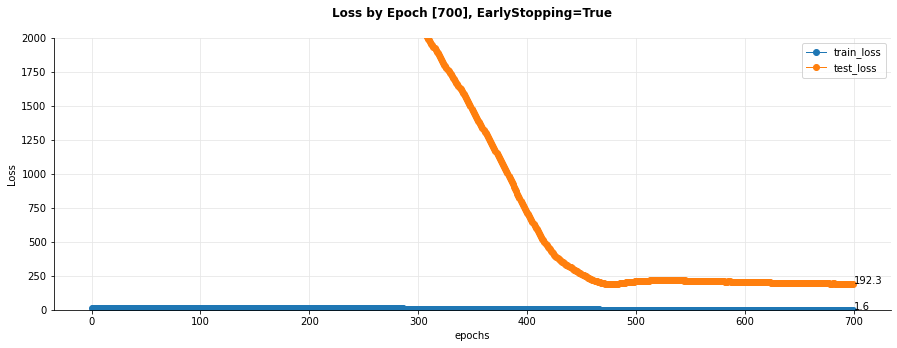

In [19]:
%%time
res = nn_manager_cut.model_fit(n_epoch=700,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#LSTM_Architecture]](#LSTM-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

# Saving Model

In [29]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_192_Bidi_2d')

INFO:tensorflow:Assets written to: ./saved_models/20210623_20H39M34S_192_Bidi_2d/assets


INFO:tensorflow:Assets written to: ./saved_models/20210623_20H39M34S_192_Bidi_2d/assets


In [21]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210619_18H21M36S_363_Bidi/')

### Plotting 

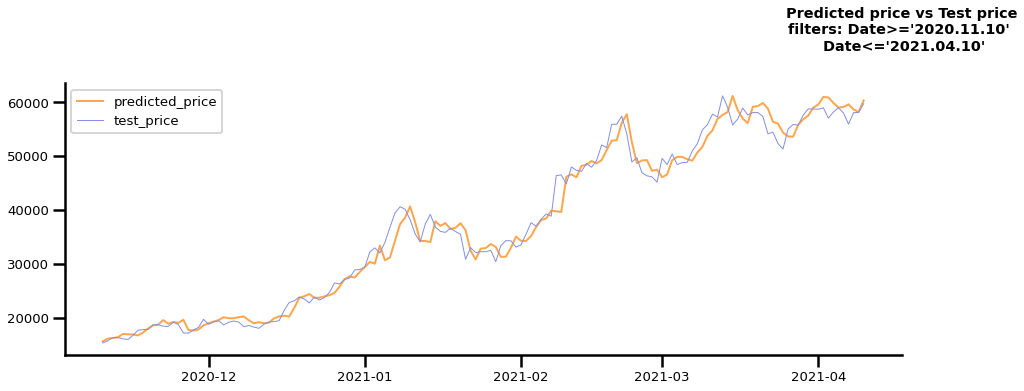

In [31]:
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.02.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"], legend_loc='upper left') 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date<='2018.03.21'"]) 


# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.06.09'", "Date<='2021.06.17'"]) 

In [23]:
# X = nn_manager_cut.X_test['2021-06-10':'2021-06-11']
# X = nn_manager_cut.scaler.transform(X)
# nn_manager_cut.model_predict(X.reshape(1, nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0] 

In [24]:
# nn_manager_cut.y_test.loc['2021-06-12']

Price    35467.5
Name: 2021-06-12 00:00:00, dtype: float64

In [25]:
# data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.07':'2018.06.09'])
# nn_manager_cut.model_predict(data_for_pred.reshape(1,
#                                                   nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0]


In [26]:
# nn_manager_cut.y_test.loc['2018.06.09']

In [27]:
nn_manager_cut.y_test_unrolled[:3]

array([[208. ],
       [211.2],
       [213.4]])

In [28]:
nn_manager_cut.y_pred[:3]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:][:3]

# Conclusion on LSTM Model: